# Sequence Model

序列数据不仅仅是关于电影评分的。下面给出了更多的场景:
- 在使用应用程序时，许多用戶都有很强的特定习惯。例如，在学生放学后社交媒体应用更受欢迎。在市 场开放时股市交易软件更常用。
- 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。毕竟，先⻅之明比事后诸葛 亮难得多。在统计学中，前者(对超出已知观测范围进行预测)称为外推法(extrapolation)，而后者(在现有观测值之间进行估计)称为内插法(interpolation)。
- 在本质上，音乐、语音、文本和视频都是连续的。如果它们的序列被我们重排，那么就会失去原有的意义。比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
- 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，这些余震的强度比非大地震后的余 震要大得多。事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
- 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。

对于一个条件概率模型：
$$
p(x_t|x1,...x_{t-1}) = p(x_t|f(x_1,...x_{t-1}))\\
p(x1,...x_{T}) = \prod_{t=1}^T p(x_t|x_1,...x_{t-1})
$$
称之为自回归模型（autoregressive models）。

1. 方案A-Markov Chain

回想一下，在自回归模型的近似法中，我们使用$x_{t−1}, . . . , x_{t−τ} $而不是$x_{t−1}, . . . , x_1$来估计$x_t$。只要这种是近似 精确的，我们就说序列满足⻢尔可夫条件(Markov condition)。特别是，如果τ = 1，得到一个 一阶⻢尔可 夫模型(first-order Markov model)，$P (x)$由下式给出:

$$
p(x1,...x_{T}) = \prod_{t=1}^T p(x_t|x_{t-1})
$$

2. 方案B-潜变量

$$
p(x1,...x_{T}) = \prod_{t=1}^T p(x_t|x_1,...x_{t-1})
$$
引入潜变量$h_t$表示过去信息$h_t = f(x_1,...x_{t-1})$,这样$x_t = p(x_t|h_t)$

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from d2l import torch as d2l

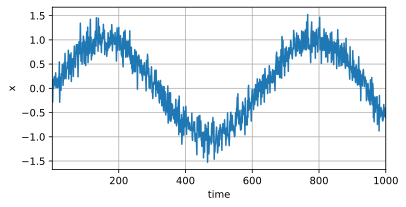

In [2]:
T =1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## Markov

In [3]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape(-1,1)    

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
batch_size, is_train=True)

1. 定义net

In [4]:
net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))

In [5]:
# 3. 初始化weight

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 4. 定义loss

l = nn.MSELoss()

# 5. 定义优化器

o = torch.optim.Adam(net.parameters(), lr=0.01)

In [6]:
# Reg Train
def eval_accu(net=None, dataset=None, cuda=False):
    accu = 0
    batch = 0
    net.eval()

    for X,y in dataset:
        if cuda:
            net.cuda()
            X,y = X.cuda(),y.cuda()
        accu += nn.MSELoss()(net(X), y)
        batch += 1
    avg_acc = accu/batch
    return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
    train_accu_history = []
    test_accu_history = []
    train_loss = []
    train_loss = []
    
    test_avg_acc_best = 0
    cos_lr = CosineAnnealingLR(o, eta_min=1e-5, T_max=10)
    for epoch in range(epochs):
    
        epoch_loss = []
        lr = o.param_groups[0]['lr']

        net.train()
        for X,y in train_iter:
            if cuda:
                net.cuda()
                X,y = X.cuda(),y.cuda()

            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            cos_lr.step()
            
        print(f'epoch {epoch + 1}, loss {eval_accu(net, train_iter).item():f}')

In [7]:
train_net(net=net, epochs=10, loss = l, optimizer=o,
          train_iter=train_iter, cuda=False)

epoch 1, loss 0.055995
epoch 2, loss 0.051983
epoch 3, loss 0.051639
epoch 4, loss 0.053226
epoch 5, loss 0.050163
epoch 6, loss 0.048710
epoch 7, loss 0.048823
epoch 8, loss 0.046460
epoch 9, loss 0.047202
epoch 10, loss 0.048174


# Prediction

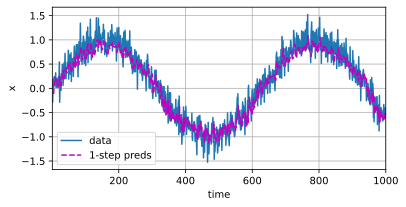

In [8]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## 多步预测

In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]

In [10]:
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

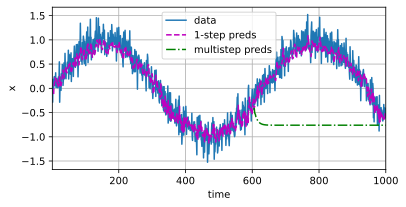

In [11]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。经过几个预测步骤之后，预测的结果很快就会衰减到一个常 数。为什么这个算法效果这么差呢?事实是由于错误的累积:假设在步骤1之后，我们积累了一些错误ε1 = ε ̄。 于是，步骤2的输入被扰动了ε1，结果积累的误差是依照次序的ε2 = ε ̄+ cε1，其中c为某个常数，后面的预测 误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来24小时的天气预报往往相当准确， 但超过这一点，精度就会迅速下降。

基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看一下k步预测的困难。

In [12]:
max_steps = 64

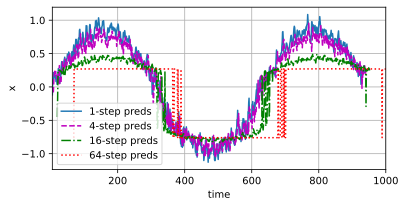

In [13]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
    figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。虽然“4步预测”看起来仍 然不错，但超过这个跨度的任何预测几乎都是无用的。